In [15]:
import sys
import os
import time

# Get the current working directory
current_dir = os.getcwd()

# Add the parent directory to sys.path
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
sys.path.insert(0, parent_dir)
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from urllib.request import urlretrieve
from scipy.stats import pearsonr

from config.config import DATA_PATH
pd.set_option('display.max_columns', None)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support, accuracy_score, roc_auc_score, average_precision_score, precision_recall_curve, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV, cross_validate
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from imblearn.ensemble import EasyEnsembleClassifier, BalancedRandomForestClassifier

from sklearn.decomposition import PCA
from sklearn.svm import SVC


In [226]:
X_train = pd.read_csv(DATA_PATH + '/modeling/X_train.csv')
X_test = pd.read_csv(DATA_PATH + '/modeling/X_test.csv')
y_train = pd.read_csv(DATA_PATH + '/modeling/y_train.csv')
y_test = pd.read_csv(DATA_PATH + '/modeling/y_test.csv')
X_train_reduced = pd.read_csv(DATA_PATH + '/modeling/X_train_10.csv')
X_test_reduced = pd.read_csv(DATA_PATH + '/modeling/X_test_10.csv')

In [227]:
y_train = y_train['cancelled']
y_test = y_test['cancelled']

In [228]:
X_train.head()

,origin_encoded,hour_of_day,dep_window_encoded,airline_ops_encoded,wind_speed_10m_origin,wind_gusts_10m_origin,wind_speed_10m_dest,wind_gusts_10m_dest,cancelled_sum_30D,airline_mkt_encoded,scheduled_elapsed_time,dep_delay_max_30D,distance,cancelled_sum_90D,month_encoded,temperature_2m_origin,temperature_2m_dest,code_share_flight,quarter,div_airport_landings_sum_30D,cancelled_sum_10D,n_flights_10D,div_airport_landings_sum_90D,div_airport_landings_sum_10D,visibility_origin,visibility_dest,dest_weather_impact_category,origin_weather_impact_category,snow_depth_dest,snow_depth_origin,precipitation_dest,precipitation_origin,wind_direction_10m_dest,wind_direction_10m_origin,is_holiday,day_of_week,day_of_month
0,-0.392666,-1.191404,-0.831642,0.114362,-1.054689,0.099992,2.247381,1.803467,-0.455582,0.790950,0.962666,1.020906,0.793271,-0.613999,0.610618,-0.378699,-0.765814,0,-0.462372,-0.044988,-0.321698,-0.485351,-0.075349,-0.026067,-0.803722,-1.568529,4.093543,-0.240644,-0.097696,-0.09847,0.196989,-0.059103,-1.538187,0.527084,0,1.513039,1.627043
1,-0.392666,1.374386,1.653785,0.114362,0.383432,1.007014,-1.006400,-1.049016,-0.455582,0.790950,0.864121,-0.854923,0.490951,-0.613999,-0.024426,0.764768,-0.568275,0,-1.361143,-0.044988,-0.321698,-0.375945,-0.075349,-0.026067,-0.577887,-0.492279,-0.240942,-0.240644,-0.097696,-0.09847,-0.060985,-0.059103,-1.377210,-0.133266,0,0.513360,1.741076
2,-0.503124,0.190175,-0.460922,-0.702297,-0.078821,0.156681,-0.928929,-0.441804,-0.455582,-0.491204,2.879816,-1.741141,2.311011,-0.613999,0.858989,-0.591698,-1.160893,0,-1.361143,-0.044988,-0.321698,-0.922973,-0.075349,-0.026067,1.214675,-0.651376,-0.240942,-0.240644,-0.097696,-0.09847,-0.060985,-0.059103,0.725541,-1.023739,0,-1.485998,1.627043
3,-0.392666,0.979649,1.128300,0.114362,-1.593984,-1.147163,-0.903105,-0.921925,1.075347,0.790950,0.210140,1.109528,-0.346952,1.225667,0.269856,2.266969,1.102344,0,0.436398,-0.044988,-0.321698,-0.485351,-0.075349,-0.026067,1.186446,-0.698170,-0.240942,-0.240644,-0.097696,-0.09847,-0.060985,-0.059103,-0.260438,-0.983718,0,-1.485998,-0.197480
4,-0.900817,-0.007193,-0.460922,-0.702297,-0.258586,-0.353519,0.465549,-0.060532,-0.455582,-0.491204,-0.775311,-1.179869,-0.265617,-0.613999,-1.574777,-0.272200,-1.262485,0,1.335169,-0.044988,-0.321698,-0.485351,-0.075349,-0.026067,1.054709,0.209624,-0.240942,-0.240644,-0.097696,-0.09847,-0.060985,-0.059103,1.359384,-0.133266,0,0.013520,1.627043


In [229]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

## Model Selection, Evaluation and GridSearch Functions

In [29]:
cross_val_results = pd.DataFrame(columns=['model_name', 'model', 'mean_f1', 'mean_recall', 'mean_precision'])

In [30]:
def cross_validate_model(model_name, model, X_train, y_train):

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    
    scoring = ['f1', 'recall', 'precision']

    scores = cross_validate(model, X_train, y_train, scoring=scoring, cv=kf, n_jobs=-1)

    mean_f1 = scores['test_f1'].mean()
    mean_recall = scores['test_recall'].mean()
    mean_precision = scores['test_precision'].mean()

    cross_val_results.loc[len(cross_val_results)] = [model_name, model, mean_f1, mean_recall, mean_precision]

    return cross_val_results


In [163]:
def evaluate_model(model_name, model, X_train, y_train, X_test, y_test, params=None):


    start_time = time.time()

    if params:
        model.set_params(**params)

    model.fit(X_train, y_train)
    
    # Predict
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)

    end_time = time.time()
    elapsed_time = end_time - start_time

    # calculate metrics
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    accuracy = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_proba[:,1])
    auprc = average_precision_score(y_test, y_pred_proba[:,1])

    feature_importances_df = None
    if hasattr(model, "feature_importances_"):        
        data = list(zip(X_test.columns, model.feature_importances_))
        feature_importances_df = pd.DataFrame(data=data, columns=['Feature', 'Feature Importance'])
    
    metrics =  {
        'model_name': model_name,
        'model': model, 
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'auprc': auprc,
        'parameters': params if params else dict(model.get_params()),
        'training_testing_time_seconds': elapsed_time

    }

    print(f'Results for {model_name} model:')
    print('Classifcation report: \n', classification_report(y_test, y_pred))
    print()
    print('Confusion matrix: \n', confusion_matrix(y_test, y_pred))

    return pd.DataFrame([metrics]), y_pred, y_pred_proba, feature_importances_df



In [23]:
def grid_search_model(model, params, X_train, y_train):

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

    gs = GridSearchCV(model, param_grid=params, cv=kf, scoring='recall', n_jobs=-1)

    gs_fit = gs.fit(X_train, y_train)

    best_estimator, best_params = gs_fit.best_estimator_, gs_fit.best_params_

    return best_estimator, best_params

In [12]:
from sklearn.model_selection import RandomizedSearchCV

def random_grid_search_model(model, params, X_train, y_train):

    kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=40)

    rs  = RandomizedSearchCV(model, params, n_iter=50, n_jobs=-1, cv=kf)

    rs_fit = rs.fit(X_train, y_train)

    best_estimator, best_params = rs_fit.best_estimator_, rs_fit.best_params_

    return best_estimator, best_params

# Baseline Models & Performance

In [230]:
models_dict = {
    'LogReg_base_cv': LogisticRegression(random_state=44),
    'RF_base_cv': RandomForestClassifier(random_state=44),
    'GB_base_cv': GradientBoostingClassifier(random_state=44),
    'Balanced_RF_cv': BalancedRandomForestClassifier(random_state=44),
    'Easy_Ensemble_cv': EasyEnsembleClassifier(random_state=44)
}

In [231]:
for name, model in models_dict.items():
    cross_val_results = cross_validate_model(name, model, X_train, y_train)

top_models = cross_val_results.sort_values(by="mean_f1", ascending=False)


/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementat

In [232]:
top_models

,model_name,model,mean_f1,mean_recall,mean_precision
11,RF_base_cv,RandomForestClassifier(random_state=44),0.283488,0.171023,0.828089
6,RF_base_cv,RandomForestClassifier(random_state=44),0.270754,0.161536,0.836164
1,RF_base_cv,RandomForestClassifier(random_state=44),0.242341,0.141701,0.836688
8,Balanced_RF_cv,BalancedRandomForestClassifier(random_state=44),0.189699,0.999602,0.104793
13,Balanced_RF_cv,BalancedRandomForestClassifier(random_state=44),0.189551,0.999403,0.104705
3,Balanced_RF_cv,BalancedRandomForestClassifier(random_state=44),0.189511,0.999204,0.104682
4,Easy_Ensemble_cv,EasyEnsembleClassifier(random_state=44),0.188266,1.000000,0.103915
9,Easy_Ensemble_cv,EasyEnsembleClassifier(random_state=44),0.188266,1.000000,0.103915
14,Easy_Ensemble_cv,EasyEnsembleClassifier(random_state=44),0.188266,1.000000,0.103915
12,GB_base_cv,GradientBoostingClassifier(random_state=44),0.166912,0.094401,0.723664


# Evaluate Best Base Models

In [233]:
rf_model = RandomForestClassifier(random_state=44)

rf_base_result, y_pred_rf, y_pred_proba_rf, rf_feature_importances = evaluate_model('RF_base', rf_model, X_train, y_train, X_test, y_test)
model_results = rf_base_result

Results for RF_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441670
           1       0.83      0.20      0.32      6460

    accuracy                           0.99    448130
   macro avg       0.91      0.60      0.66    448130
weighted avg       0.99      0.99      0.98    448130


Confusion matrix: 
 [[441411    259]
 [  5189   1271]]


In [235]:
balanced_rf_model = BalancedRandomForestClassifier(random_state=44)

balanced_rf_result, y_pred, y_pred_proba, balanced_rf_feature_importances = evaluate_model('Balanced_RF_base', balanced_rf_model, X_train, y_train, X_test, y_test)


/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementat

Results for Balanced_RF_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.93    441670
           1       0.11      1.00      0.19      6460

    accuracy                           0.88    448130
   macro avg       0.55      0.94      0.56    448130
weighted avg       0.99      0.88      0.92    448130


Confusion matrix: 
 [[386662  55008]
 [     4   6456]]


In [236]:
model_results = pd.concat([model_results, balanced_rf_result], axis=0, ignore_index=True)

In [237]:
easy_ens_model = EasyEnsembleClassifier(random_state=44)

easy_ens_base_result, y_pred, y_pred_proba, _ = evaluate_model('Easy_Ensemble_base', easy_ens_model, X_train, y_train, X_test, y_test)


Results for Easy_Ensemble_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    441670
           1       0.10      1.00      0.19      6460

    accuracy                           0.88    448130
   macro avg       0.55      0.94      0.56    448130
weighted avg       0.99      0.88      0.92    448130


Confusion matrix: 
 [[385901  55769]
 [     0   6460]]


In [238]:
model_results = pd.concat([model_results, easy_ens_base_result], axis=0, ignore_index=True)

In [239]:
gb_model = GradientBoostingClassifier(random_state=44)

gb_base_result, y_pred_gb, y_pred_proba_gb, gb_feature_importances = evaluate_model('GB_base', gb_model, X_train, y_train, X_test, y_test)


Results for GB_base model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99    441670
           1       0.70      0.10      0.17      6460

    accuracy                           0.99    448130
   macro avg       0.84      0.55      0.58    448130
weighted avg       0.98      0.99      0.98    448130


Confusion matrix: 
 [[441404    266]
 [  5845    615]]


In [240]:
model_results = pd.concat([model_results, gb_base_result], axis=0, ignore_index=True)

In [241]:
model_results.sort_values('recall', ascending=False)

,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters,training_testing_time_seconds
2,Easy_Ensemble_base,"((RandomUnderSampler(random_state=1165046975),...",0.875552,0.103810,1.000000,0.188094,0.965197,0.263531,"{'estimator': None, 'n_estimators': 10, 'n_job...",26.569484
1,Balanced_RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.877241,0.105037,0.999381,0.190095,0.972830,0.345453,"{'bootstrap': 'warn', 'ccp_alpha': 0.0, 'class...",14.295756
0,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987843,0.830719,0.196749,0.318148,0.977299,0.513766,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",60.719895
3,GB_base,([DecisionTreeRegressor(criterion='friedman_ms...,0.986363,0.698070,0.095201,0.167552,0.971670,0.374599,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",204.836824


In [50]:
model_results.to_csv('./model_results/model_results.10.25_v1.csv', index=False)

# Hyper Parameter Tuning

In [43]:
sss = StratifiedShuffleSplit(n_splits=1, train_size=0.3, random_state=42)
for train_index, _ in sss.split(X_train, y_train):
    X_train_sample, y_train_sample = X_train.iloc[train_index], y_train.iloc[train_index]

In [44]:
rf_param_grid = {
    'n_estimators':[350, 500],
    'criterion': ['gini', 'entropy'],
    'max_depth':[10, 20, None],
    'max_features':['sqrt', 'log2', None],
    'class_weight': [None, 'balanced', 'balanced_subsample'],
    'n_jobs': [-1], 
    'random_state':[40]}

rf_best_model, rf_best_params = grid_search_model(RandomForestClassifier(random_state=44), params=rf_param_grid, X_train=X_train_sample, y_train=y_train_sample)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [45]:
rf_best_params

{'class_weight': 'balanced',
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'log2',
 'n_estimators': 350,
 'n_jobs': -1,
 'random_state': 40}

In [243]:
rf_metrics, y_pred_rf, y_pred_proba_rf, rf_feature_importances = evaluate_model(model_name='RF_grid_search', 
                                                  model=RandomForestClassifier(random_state=44), 
                                                  X_train=X_train, 
                                                  y_train=y_train, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=rf_best_params)
    


Results for RF_grid_search model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    441670
           1       0.10      1.00      0.19      6460

    accuracy                           0.88    448130
   macro avg       0.55      0.94      0.56    448130
weighted avg       0.99      0.88      0.92    448130


Confusion matrix: 
 [[386117  55553]
 [     0   6460]]


In [244]:
model_results = pd.concat([model_results, rf_metrics], axis=0, ignore_index=True)

In [47]:
balanced_rf_param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [None, 10, 20, 30],
    'min_samples_leaf': [10],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'sampling_strategy': ['auto', 0.5]
}

best_model_brf, best_params_brf = random_grid_search_model(BalancedRandomForestClassifier(random_state=40), 
                                                           params=balanced_rf_param_grid, 
                                                           X_train=X_train_sample, 
                                                           y_train=y_train_sample)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation prop

In [216]:
best_params_brf

{'sampling_strategy': 0.5,
 'n_estimators': 50,
 'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_features': 'log2',
 'max_depth': 20}

In [245]:
brf_metrics, y_pred_brf, y_pred_proba_brf, brf_feature_importances = evaluate_model(model_name='Balanced_RF_grid_search', 
                                                  model=BalancedRandomForestClassifier(random_state=40), 
                                                  X_train=X_train, 
                                                  y_train=y_train, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=best_params_brf)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Results for Balanced_RF_grid_search model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.89      0.94    441670
           1       0.11      0.99      0.20      6460

    accuracy                           0.89    448130
   macro avg       0.56      0.94      0.57    448130
weighted avg       0.99      0.89      0.93    448130


Confusion matrix: 
 [[391014  50656]
 [    53   6407]]


In [246]:
brf_metrics_2, y_pred_brf_2, y_pred_proba_brf_2, brf_feature_importances_2 = evaluate_model(model_name='Balanced_RF_grid_search', 
                                                  model=BalancedRandomForestClassifier(random_state=40), 
                                                  X_train=X_train_reduced, 
                                                  y_train=y_train, 
                                                  X_test=X_test_reduced, 
                                                  y_test=y_test, 
                                                  params=best_params_brf)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `False` to silence this warning and adopt the future behaviour.
  warn(


Results for Balanced_RF_grid_search model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.88      0.93    441670
           1       0.11      1.00      0.19      6460

    accuracy                           0.88    448130
   macro avg       0.55      0.94      0.56    448130
weighted avg       0.99      0.88      0.92    448130


Confusion matrix: 
 [[387073  54597]
 [    22   6438]]


In [247]:
brf_feature_importances_2.sort_values('Feature Importance', ascending=False)

,Feature,Feature Importance
0,cancelled_sum_10D,0.598028
1,cancelled_sum_30D,0.221080
2,cancelled_sum_90D,0.064570
3,month_encoded,0.034782
6,visibility_dest,0.034519
8,origin_encoded,0.015079
9,quarter,0.012839
4,airline_ops_encoded,0.012336
5,origin_weather_impact_category,0.004819
7,dest_weather_impact_category,0.001948


In [248]:
brf_feature_importances.sort_values('Feature Importance', ascending=False)

,Feature,Feature Importance
20,cancelled_sum_10D,0.427651
8,cancelled_sum_30D,0.225709
13,cancelled_sum_90D,0.069795
21,n_flights_10D,0.064396
14,month_encoded,0.035627
25,visibility_dest,0.018067
24,visibility_origin,0.015765
36,day_of_month,0.011576
16,temperature_2m_dest,0.010660
15,temperature_2m_origin,0.010072


In [249]:
model_results = pd.concat([model_results, brf_metrics], axis=0, ignore_index=True)

In [55]:
easy_ensemble_param_grid = {
    'n_estimators': [10, 50, 100], 
    'replacement': [True, False],
    'sampling_strategy': ['auto', 0.5, 0.7]
}

best_model_ee, best_params_ee = random_grid_search_model(EasyEnsembleClassifier(random_state=40), 
                                                           params=easy_ensemble_param_grid, 
                                                           X_train=X_train_sample, 
                                                           y_train=y_train_sample)

/Users/katialopes-gilbert/opt/anaconda3/envs/data-course/lib/python3.11/site-packages/sklearn/model_selection/_search.py:318: UserWarning: The total space of parameters 18 is smaller than n_iter=50. Running 18 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [108]:
best_params_ee

{'sampling_strategy': 0.5, 'replacement': True, 'n_estimators': 10}

In [250]:
ee_metrics, y_pred_ee, y_pred_proba_ee, _ = evaluate_model(model_name='Easy_Ensemble_grid_search', 
                                                  model=EasyEnsembleClassifier(random_state=40), 
                                                  X_train=X_train, 
                                                  y_train=y_train, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=best_params_ee)
    


Results for Easy_Ensemble_grid_search model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    441670
           1       0.10      1.00      0.19      6460

    accuracy                           0.88    448130
   macro avg       0.55      0.94      0.56    448130
weighted avg       0.99      0.88      0.92    448130


Confusion matrix: 
 [[385901  55769]
 [     0   6460]]


In [251]:
model_results = pd.concat([model_results, brf_metrics], axis=0, ignore_index=True)

In [252]:
model_results.sort_values('f1', ascending=False)

,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters,training_testing_time_seconds
0,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987843,0.830719,0.196749,0.318148,0.977299,0.513766,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",60.719895
5,Balanced_RF_grid_search,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.886843,0.112279,0.991796,0.201722,0.974271,0.405410,"{'sampling_strategy': 0.5, 'n_estimators': 50,...",7.913678
6,Balanced_RF_grid_search,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.886843,0.112279,0.991796,0.201722,0.974271,0.405410,"{'sampling_strategy': 0.5, 'n_estimators': 50,...",7.913678
1,Balanced_RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.877241,0.105037,0.999381,0.190095,0.972830,0.345453,"{'bootstrap': 'warn', 'ccp_alpha': 0.0, 'class...",14.295756
4,RF_grid_search,"(DecisionTreeClassifier(max_depth=10, max_feat...",0.876034,0.104172,1.000000,0.188688,0.970387,0.362686,"{'class_weight': 'balanced', 'criterion': 'gin...",26.823808
2,Easy_Ensemble_base,"((RandomUnderSampler(random_state=1165046975),...",0.875552,0.103810,1.000000,0.188094,0.965197,0.263531,"{'estimator': None, 'n_estimators': 10, 'n_job...",26.569484
3,GB_base,([DecisionTreeRegressor(criterion='friedman_ms...,0.986363,0.698070,0.095201,0.167552,0.971670,0.374599,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",204.836824


In [253]:
model_results.sort_values('recall', ascending=False)

,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters,training_testing_time_seconds
2,Easy_Ensemble_base,"((RandomUnderSampler(random_state=1165046975),...",0.875552,0.103810,1.000000,0.188094,0.965197,0.263531,"{'estimator': None, 'n_estimators': 10, 'n_job...",26.569484
4,RF_grid_search,"(DecisionTreeClassifier(max_depth=10, max_feat...",0.876034,0.104172,1.000000,0.188688,0.970387,0.362686,"{'class_weight': 'balanced', 'criterion': 'gin...",26.823808
1,Balanced_RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.877241,0.105037,0.999381,0.190095,0.972830,0.345453,"{'bootstrap': 'warn', 'ccp_alpha': 0.0, 'class...",14.295756
5,Balanced_RF_grid_search,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.886843,0.112279,0.991796,0.201722,0.974271,0.405410,"{'sampling_strategy': 0.5, 'n_estimators': 50,...",7.913678
6,Balanced_RF_grid_search,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.886843,0.112279,0.991796,0.201722,0.974271,0.405410,"{'sampling_strategy': 0.5, 'n_estimators': 50,...",7.913678
0,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987843,0.830719,0.196749,0.318148,0.977299,0.513766,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",60.719895
3,GB_base,([DecisionTreeRegressor(criterion='friedman_ms...,0.986363,0.698070,0.095201,0.167552,0.971670,0.374599,"{'ccp_alpha': 0.0, 'criterion': 'friedman_mse'...",204.836824


## Additional Class Imbalance Techniques

In [254]:
undersampler = RandomUnderSampler(random_state=40)
X_train_rus, y_train_rus = undersampler.fit_resample(X_train, y_train)

rf_metrics_rus, y_pred_rus, y_pred_proba_rus, _ = evaluate_model(model_name='RF_random_undersample', 
                                                  model=RandomForestClassifier(random_state=40), 
                                                  X_train=X_train_rus, 
                                                  y_train=y_train_rus, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=rf_best_params)

Results for RF_random_undersample model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    441670
           1       0.10      1.00      0.19      6460

    accuracy                           0.88    448130
   macro avg       0.55      0.94      0.56    448130
weighted avg       0.99      0.88      0.92    448130


Confusion matrix: 
 [[385901  55769]
 [     0   6460]]


In [255]:
model_results = pd.concat([model_results, rf_metrics_rus], axis=0, ignore_index=True)

In [256]:
undersampler_nm = NearMiss(version=1)

X_train_nm1, y_train_nm1 = undersampler_nm.fit_resample(X_train, y_train)

In [257]:
rf_metrics_nm1, y_pred_nm1, y_pred_proba_nm1, _ = evaluate_model(model_name='RF_undersample_nm_1', 
                                                  model=RandomForestClassifier(random_state=40), 
                                                  X_train=X_train_nm1, 
                                                  y_train=y_train_nm1, 
                                                  X_test=X_test, 
                                                  y_test=y_test,
                                                  params=rf_best_params)

Results for RF_undersample_nm_1 model:
Classifcation report: 
               precision    recall  f1-score   support

           0       0.99      0.87      0.93    441670
           1       0.07      0.70      0.14      6460

    accuracy                           0.87    448130
   macro avg       0.53      0.79      0.53    448130
weighted avg       0.98      0.87      0.92    448130


Confusion matrix: 
 [[386003  55667]
 [  1950   4510]]


In [258]:
model_results = pd.concat([model_results, rf_metrics_nm1], axis=0, ignore_index=True)

In [259]:
tomek = TomekLinks()

X_train_tomek, y_train_tomek = tomek.fit_resample(X_train, y_train)

In [260]:
rf_tomek_metrics, y_pred_tomek, y_pred_proba_tomek, _ = evaluate_model(model_name='RF_tomek', 
                                                  model=RandomForestClassifier(random_state=40), 
                                                  X_train=X_train_tomek, 
                                                  y_train=y_train_tomek, 
                                                  X_test=X_test, 
                                                  y_test=y_test, 
                                                  params=rf_best_params)

Results for RF_tomek model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.87      0.93    441670
           1       0.10      1.00      0.19      6460

    accuracy                           0.88    448130
   macro avg       0.55      0.94      0.56    448130
weighted avg       0.99      0.88      0.92    448130


Confusion matrix: 
 [[386079  55591]
 [     0   6460]]


In [261]:
model_results = pd.concat([model_results, rf_tomek_metrics], axis=0, ignore_index=True)

In [262]:
undersampler_nm_3 = NearMiss(version=3, n_neighbors=10)

X_train_undersampled_3, y_train_undersampled_3 = undersampler_nm_3.fit_resample(X_train, y_train)

In [263]:
rf_nm3_metrics, y_pred_nm3, y_pred_proba_nm3, _ = evaluate_model(model_name='RF_undersample_nm_3', 
                                                  model=RandomForestClassifier(random_state=40), 
                                                  X_train=X_train_undersampled_3, 
                                                  y_train=y_train_undersampled_3, 
                                                  X_test=X_test, 
                                                  y_test=y_test)

Results for RF_undersample_nm_3 model:
Classifcation report: 
               precision    recall  f1-score   support

           0       1.00      0.91      0.95    441670
           1       0.13      0.87      0.22      6460

    accuracy                           0.91    448130
   macro avg       0.56      0.89      0.59    448130
weighted avg       0.99      0.91      0.94    448130


Confusion matrix: 
 [[402489  39181]
 [   843   5617]]


In [264]:
model_results = pd.concat([model_results, rf_nm3_metrics], axis=0, ignore_index=True)

In [265]:
model_results.sort_values('recall', ascending=False)

,model_name,model,accuracy,precision,recall,f1,roc_auc,auprc,parameters,training_testing_time_seconds
2,Easy_Ensemble_base,"((RandomUnderSampler(random_state=1165046975),...",0.875552,0.103810,1.000000,0.188094,0.965197,0.263531,"{'estimator': None, 'n_estimators': 10, 'n_job...",26.569484
4,RF_grid_search,"(DecisionTreeClassifier(max_depth=10, max_feat...",0.876034,0.104172,1.000000,0.188688,0.970387,0.362686,"{'class_weight': 'balanced', 'criterion': 'gin...",26.823808
7,RF_random_undersample,"(DecisionTreeClassifier(max_depth=10, max_feat...",0.875552,0.103810,1.000000,0.188094,0.970254,0.344216,"{'class_weight': 'balanced', 'criterion': 'gin...",1.750914
9,RF_tomek,"(DecisionTreeClassifier(max_depth=10, max_feat...",0.875949,0.104108,1.000000,0.188583,0.970500,0.361311,"{'class_weight': 'balanced', 'criterion': 'gin...",25.225715
1,Balanced_RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.877241,0.105037,0.999381,0.190095,0.972830,0.345453,"{'bootstrap': 'warn', 'ccp_alpha': 0.0, 'class...",14.295756
5,Balanced_RF_grid_search,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.886843,0.112279,0.991796,0.201722,0.974271,0.405410,"{'sampling_strategy': 0.5, 'n_estimators': 50,...",7.913678
6,Balanced_RF_grid_search,"(DecisionTreeClassifier(max_depth=20, max_feat...",0.886843,0.112279,0.991796,0.201722,0.974271,0.405410,"{'sampling_strategy': 0.5, 'n_estimators': 50,...",7.913678
10,RF_undersample_nm_3,"(DecisionTreeClassifier(max_features='sqrt', r...",0.910687,0.125385,0.869505,0.219166,0.953693,0.156586,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",6.501651
8,RF_undersample_nm_1,"(DecisionTreeClassifier(max_depth=10, max_feat...",0.871428,0.074946,0.698142,0.135360,0.887168,0.176812,"{'class_weight': 'balanced', 'criterion': 'gin...",2.249504
0,RF_base,"(DecisionTreeClassifier(max_features='sqrt', r...",0.987843,0.830719,0.196749,0.318148,0.977299,0.513766,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...",60.719895


In [64]:
model_results.to_csv('./model_results/model_results.10.27.csv', index=False)


# Adjusting Probability Thresholds

### NearMiss Version 3

In [90]:
baseline = len(y[y==1])/len(y)

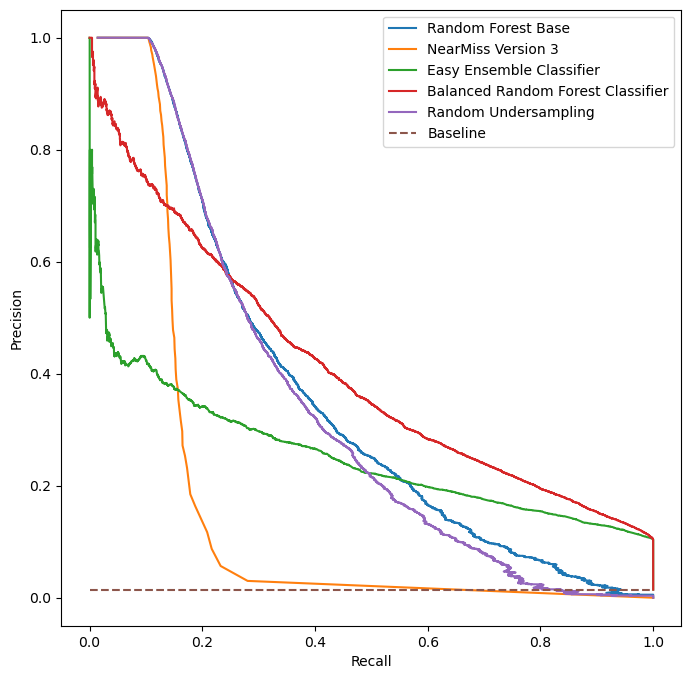

In [266]:
fig, ax = plt.subplots(figsize=(8,8))
# calculate model precision-recall curve
precision_rf, recall_rf, _ = precision_recall_curve(y_test, y_pred_proba_rf[:,1])
# plot the model precision-recall curve
plt.plot(precision_rf, recall_rf, label='Random Forest Base')

# calculate model precision-recall curve
precision_nm3, recall_nm3, _ = precision_recall_curve(y_test, y_pred_proba_nm3[:,1])
# plot the model precision-recall curve
plt.plot(precision_nm3, recall_nm3, label='NearMiss Version 3')

# calculate model precision-recall curve
precision_ee, recall_ee, _ = precision_recall_curve(y_test, y_pred_proba_ee[:,1])
# plot the model precision-recall curve
plt.plot(recall_ee, precision_ee, label='Easy Ensemble Classifier')

# calculate model precision-recall curve
precision_brf, recall_brf, _ = precision_recall_curve(y_test, y_pred_proba_brf[:,1])
# plot the model precision-recall curve
plt.plot(recall_brf, precision_brf, label='Balanced Random Forest Classifier')

precision_rus, recall_rus, _ = precision_recall_curve(y_test, y_pred_proba_rus[:,1])
# plot the model precision-recall curve
plt.plot(precision_rus, recall_rus, label='Random Undersampling')

plt.plot([0, 1], [baseline, baseline], linestyle='--', label='Baseline')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [120]:
def evaluate_with_custom_threshold(y_test, y_pred_proba, threshold):
    y_pred_custom = (y_pred_proba >= threshold).astype(int)

    print("Classification Report:")
    print(classification_report(y_test, y_pred_custom))
    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_pred_custom))

    return y_pred_custom

In [273]:
evaluate_with_custom_threshold(y_test, y_pred_proba_brf[:,1], 0.67)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97    441670
           1       0.16      0.88      0.28      6460

    accuracy                           0.93    448130
   macro avg       0.58      0.90      0.62    448130
weighted avg       0.99      0.93      0.96    448130


Confusion Matrix:
[[412706  28964]
 [   804   5656]]


array([0, 0, 0, ..., 0, 1, 0])

In [211]:
evaluate_with_custom_threshold(y_test, y_pred_proba_brf[:,1], 0.5)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.88      0.94    441670
           1       0.11      0.99      0.20      6460

    accuracy                           0.88    448130
   macro avg       0.55      0.94      0.57    448130
weighted avg       0.99      0.88      0.93    448130


Confusion Matrix:
[[389760  51910]
 [    45   6415]]


array([0, 0, 0, ..., 0, 1, 0])

In [195]:
evaluate_with_custom_threshold(y_test, y_pred_proba_ee[:,1], 0.53)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.91      0.95    441670
           1       0.13      0.92      0.22      6460

    accuracy                           0.91    448130
   macro avg       0.56      0.91      0.59    448130
weighted avg       0.99      0.91      0.94    448130


Confusion Matrix:
[[401292  40378]
 [   527   5933]]


array([0, 0, 0, ..., 0, 1, 0])

In [272]:
evaluate_with_custom_threshold(y_test, y_pred_proba_rf[:,1], 0.8)

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97    441670
           1       0.18      0.78      0.29      6460

    accuracy                           0.95    448130
   macro avg       0.59      0.86      0.63    448130
weighted avg       0.98      0.95      0.96    448130


Confusion Matrix:
[[418871  22799]
 [  1443   5017]]


array([0, 0, 0, ..., 0, 1, 0])

In [274]:
true_positives = X_test[(y_test == 1) & (y_pred_brf == 1)]
true_negatives = X_test[(y_test == 0) & (y_pred_brf == 0)]
false_positives = X_test[(y_test == 0) & (y_pred_brf == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred_brf == 0)]

In [275]:
false_positives

,origin_encoded,hour_of_day,dep_window_encoded,airline_ops_encoded,wind_speed_10m_origin,wind_gusts_10m_origin,wind_speed_10m_dest,wind_gusts_10m_dest,cancelled_sum_30D,airline_mkt_encoded,scheduled_elapsed_time,dep_delay_max_30D,distance,cancelled_sum_90D,month_encoded,temperature_2m_origin,temperature_2m_dest,code_share_flight,quarter,div_airport_landings_sum_30D,cancelled_sum_10D,n_flights_10D,div_airport_landings_sum_90D,div_airport_landings_sum_10D,visibility_origin,visibility_dest,dest_weather_impact_category,origin_weather_impact_category,snow_depth_dest,snow_depth_origin,precipitation_dest,precipitation_origin,wind_direction_10m_dest,wind_direction_10m_origin,is_holiday,day_of_week,day_of_month
6,-0.349301,-0.994035,-0.831642,-0.723450,-0.951966,-1.303057,-1.187165,-0.794834,0.309882,-1.102748,-0.049661,-1.224180,-0.693776,-0.246066,0.858989,-1.146616,-1.883323,0,-1.361143,-0.044988,1.246278,0.280489,-0.075349,-0.026067,-0.662575,-0.248952,-0.240942,-0.240644,1.769009,-0.09847,-0.060985,-0.059103,0.363344,0.727190,0,0.513360,-1.109741
40,-0.271924,1.177018,1.653785,-0.603766,-0.027460,-0.509413,1.111140,1.097407,1.075347,-0.647000,0.066802,0.046066,-0.532641,0.857734,1.636376,0.669479,0.611318,0,0.436398,-0.044988,1.246278,-0.594756,-0.075349,-0.026067,0.320746,-0.670094,-0.240942,-0.240644,-0.097696,-0.09847,-0.060985,-0.059103,1.339262,-1.433957,0,1.013199,1.513011
42,0.261840,-0.599298,-0.831642,-0.603766,-0.155863,0.000787,0.413902,0.306619,4.137207,-0.647000,0.675989,1.109528,0.447982,1.593600,0.698392,-0.928012,-0.449751,0,-1.361143,-0.044988,9.086158,0.061678,-0.075349,-0.026067,-0.968393,0.916206,-0.240942,4.116584,-0.097696,-0.09847,-0.060985,2.114685,0.795968,0.797228,0,-0.486319,-0.881676
50,-0.271924,0.190175,-0.460922,0.114362,-0.130183,-0.509413,2.660560,1.422194,4.137207,0.790950,0.245974,-0.781071,-0.532641,6.008799,0.269856,0.888083,1.040260,0,0.436398,-0.044988,1.246278,0.389894,-0.075349,-0.026067,0.781825,0.771146,-0.240942,-0.240644,-0.097696,-0.09847,-0.060985,-0.059103,0.826151,0.997334,0,0.513360,0.258651
77,1.470294,0.979649,1.128300,-0.702297,-0.181544,-0.665307,-0.644868,-0.512410,0.309882,-0.491204,-0.148206,0.282391,1.792309,0.121867,-0.065277,0.781583,1.356323,0,0.436398,-0.044988,1.246278,-0.594756,-0.075349,-0.026067,-0.822542,1.515163,-0.240942,-0.240644,-0.097696,-0.09847,-0.060985,-0.059103,0.383466,-0.563495,0,-1.485998,-0.539578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
448101,0.261840,0.979649,1.128300,-0.603766,0.897047,0.567675,-0.851458,-0.413562,0.309882,-0.647000,0.174305,0.976595,-0.221113,0.489800,-0.024426,-0.322647,-0.415887,0,-1.361143,-0.044988,1.246278,0.389894,-0.075349,-0.026067,-0.944869,0.948961,-0.240942,-0.240644,-0.097696,-0.09847,-0.060985,-0.059103,-0.008913,1.657684,0,0.013520,-0.767643
448106,2.531577,0.584912,0.402156,-0.702297,-0.207225,-0.381863,0.697962,1.379831,0.309882,-0.491204,-0.309461,1.109528,-0.512691,0.489800,1.103247,0.944135,1.305527,0,-0.462372,-0.044988,1.246278,-0.594756,-0.075349,-0.026067,-0.389692,0.686918,-0.240942,-0.240644,-0.097696,-0.09847,-0.060985,-0.059103,1.047493,-0.753595,0,-0.986158,1.284945
448114,-0.271924,-1.388772,-0.831642,-0.702297,-0.386990,-0.381863,-1.109694,-1.204349,0.309882,-0.491204,-0.721559,-0.795841,-1.144954,-0.246066,0.858989,-1.454904,-2.340485,0,-1.361143,-0.044988,1.246278,0.280489,-0.075349,-0.026067,-0.836656,-1.498339,-0.240942,-0.240644,17.671619,-0.09847,-0.060985,-0.059103,-0.029035,-0.513468,0,-0.986158,-0.653610
448126,1.470294,-0.204562,-1.078897,-0.299241,-0.232905,-0.764513,0.413902,-0.385319,0.309882,-0.491204,-0.694683,0.134688,-0.521898,-0.246066,-0.024426,-0.619724,-1.234265,1,-1.361143,-0.044988,1.246278,-0.594756,-0.075349,-0.026067,-0.883705,-0.459523,-0.240942,-0.240644,-0.097696,-0.09847,-0.060985,-0.059103,-1.689102,0.056835,0,0.013520,0.828814


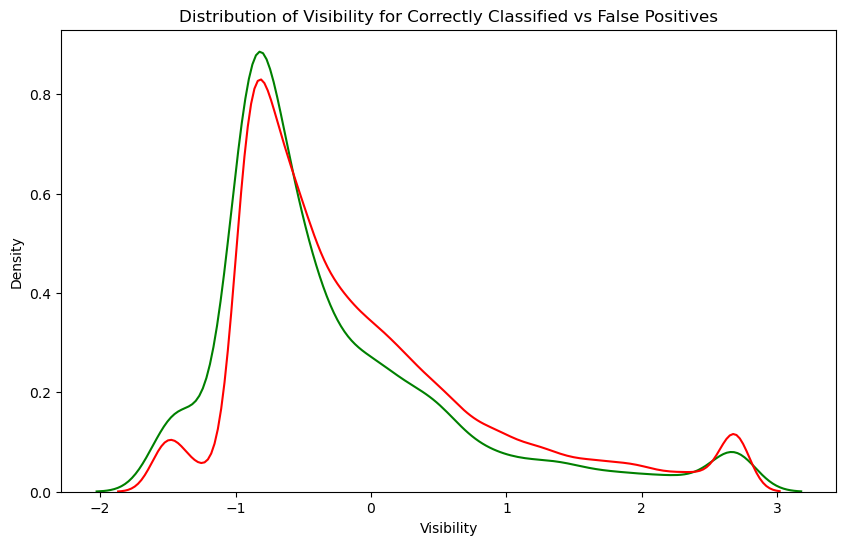

In [276]:
plt.figure(figsize=(10, 6))
sns.kdeplot(true_positives['visibility_origin'], label='Correctly Classified', color='green')
sns.kdeplot(false_positives['visibility_origin'], label='False Positives', color='red')
plt.title("Distribution of Visibility for Correctly Classified vs False Positives")
plt.xlabel("Visibility")
plt.show()

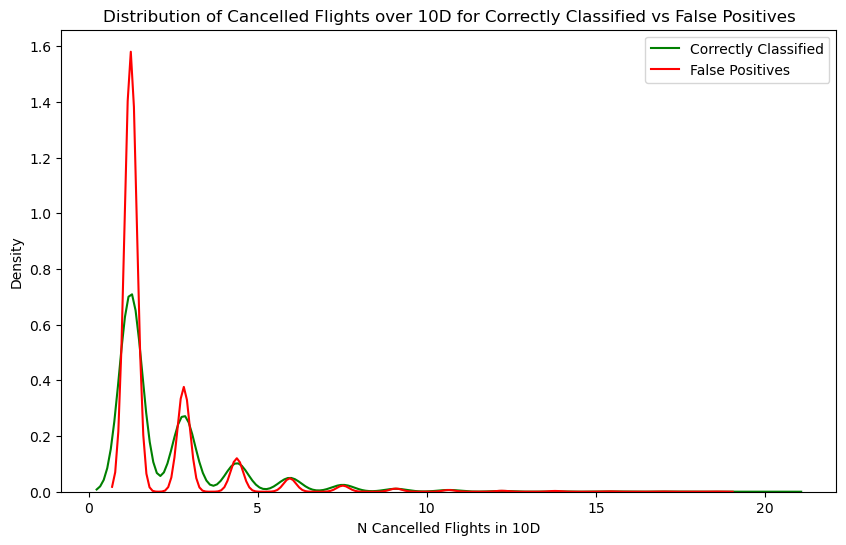

In [277]:
plt.figure(figsize=(10, 6))
sns.kdeplot(true_positives['cancelled_sum_10D'], label='Correctly Classified', color='green')
sns.kdeplot(false_positives['cancelled_sum_10D'], label='False Positives', color='red')
plt.title("Distribution of Cancelled Flights over 10D for Correctly Classified vs False Positives")
plt.xlabel("N Cancelled Flights in 10D")
plt.legend()
plt.show()

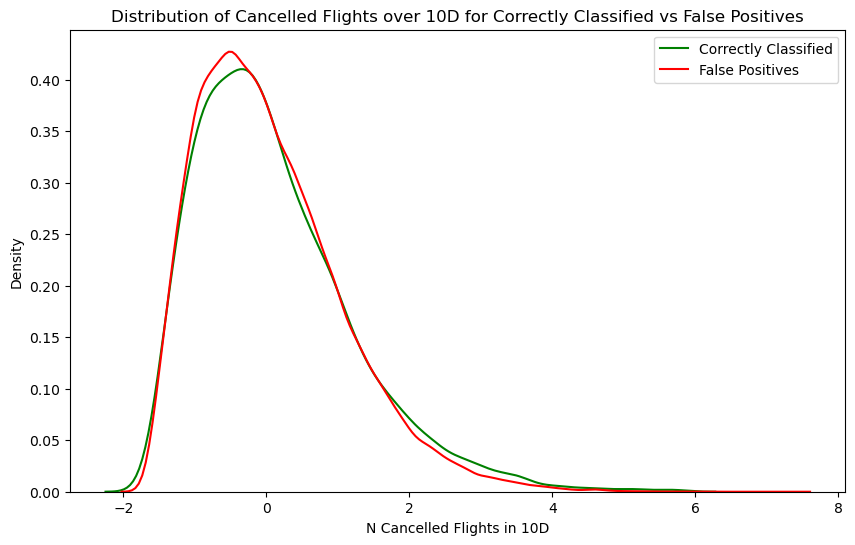

In [278]:
plt.figure(figsize=(10, 6))
sns.kdeplot(true_positives['wind_speed_10m_dest'], label='Correctly Classified', color='green')
sns.kdeplot(false_positives['wind_speed_10m_dest'], label='False Positives', color='red')
plt.title("Distribution of Cancelled Flights over 10D for Correctly Classified vs False Positives")
plt.xlabel("N Cancelled Flights in 10D")
plt.legend()
plt.show()

<Axes: >

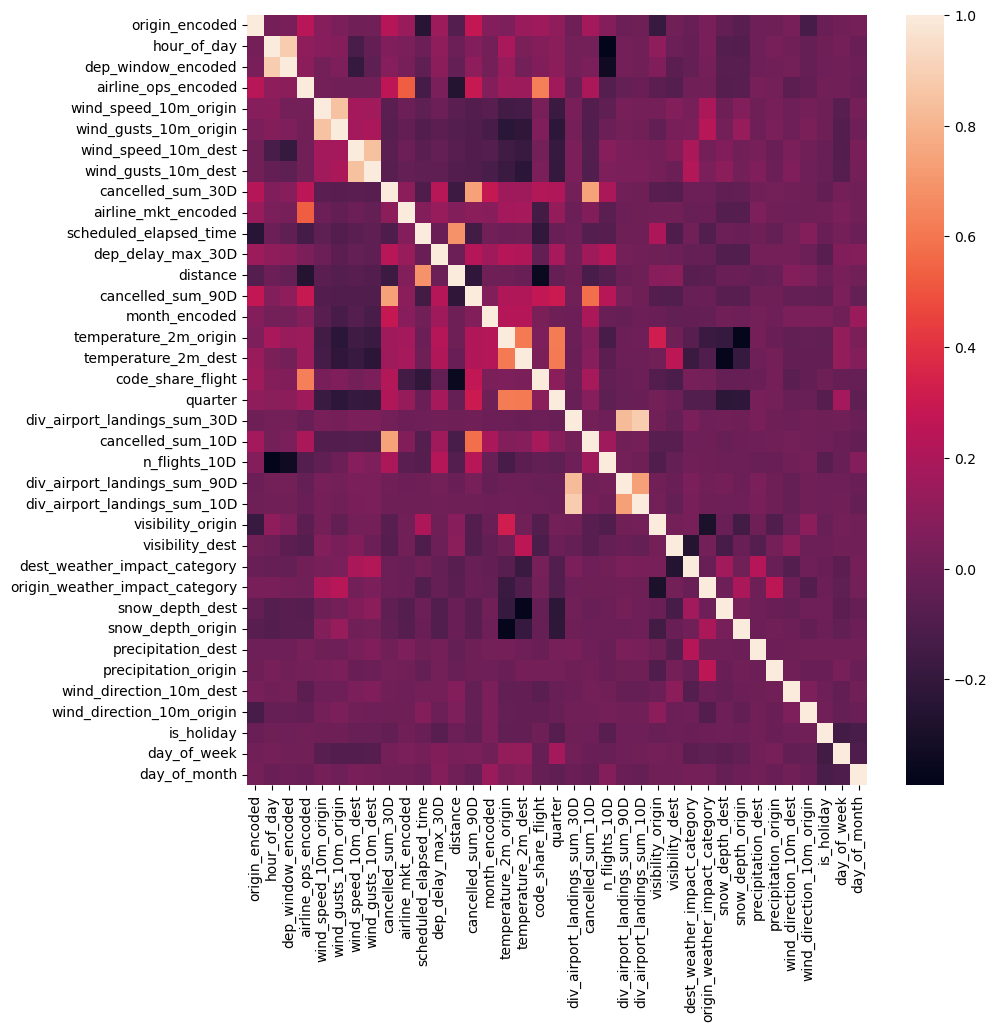

In [279]:
fig, ax = plt.subplots(figsize=(10,10))

true_positive_corr = true_positives.corr()
sns.heatmap(true_positive_corr)

<Axes: >

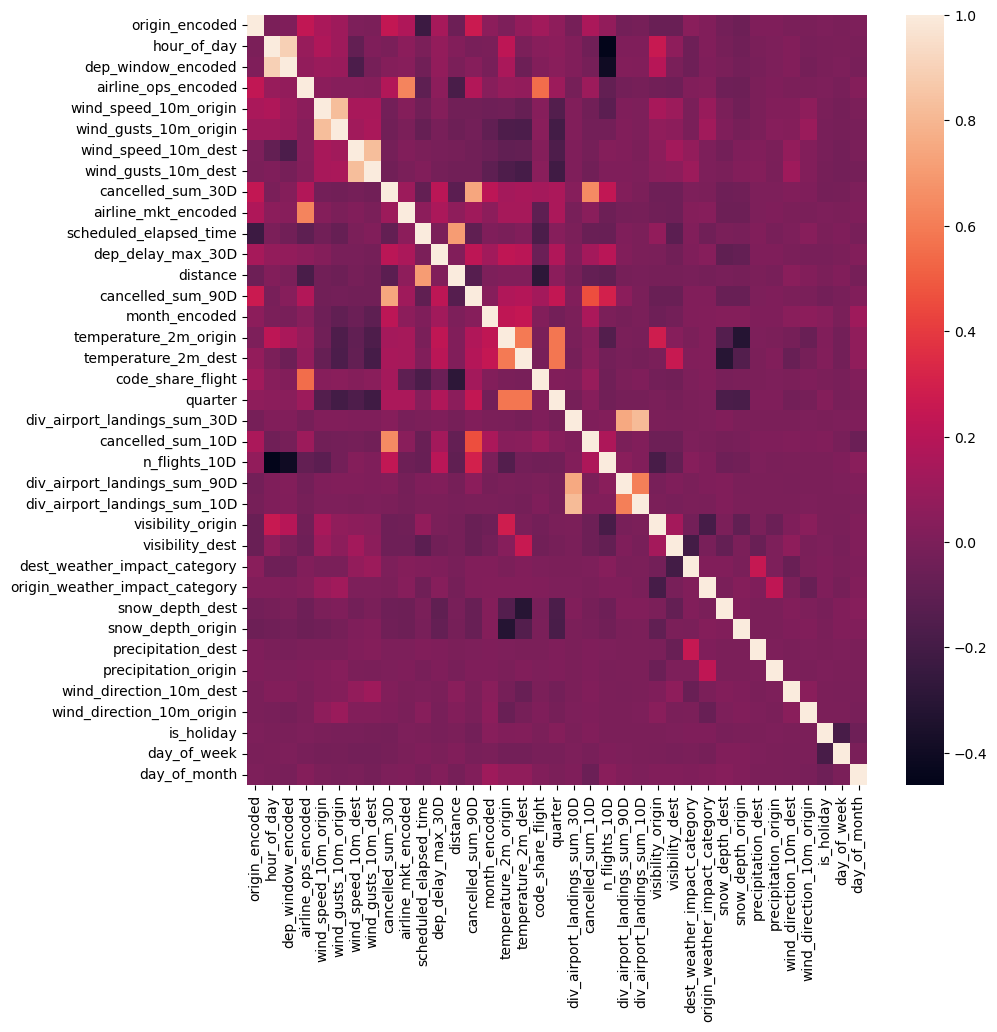

In [280]:
fig, ax = plt.subplots(figsize=(10,10))

false_positive_corr = false_positives.corr()
sns.heatmap(false_positive_corr)

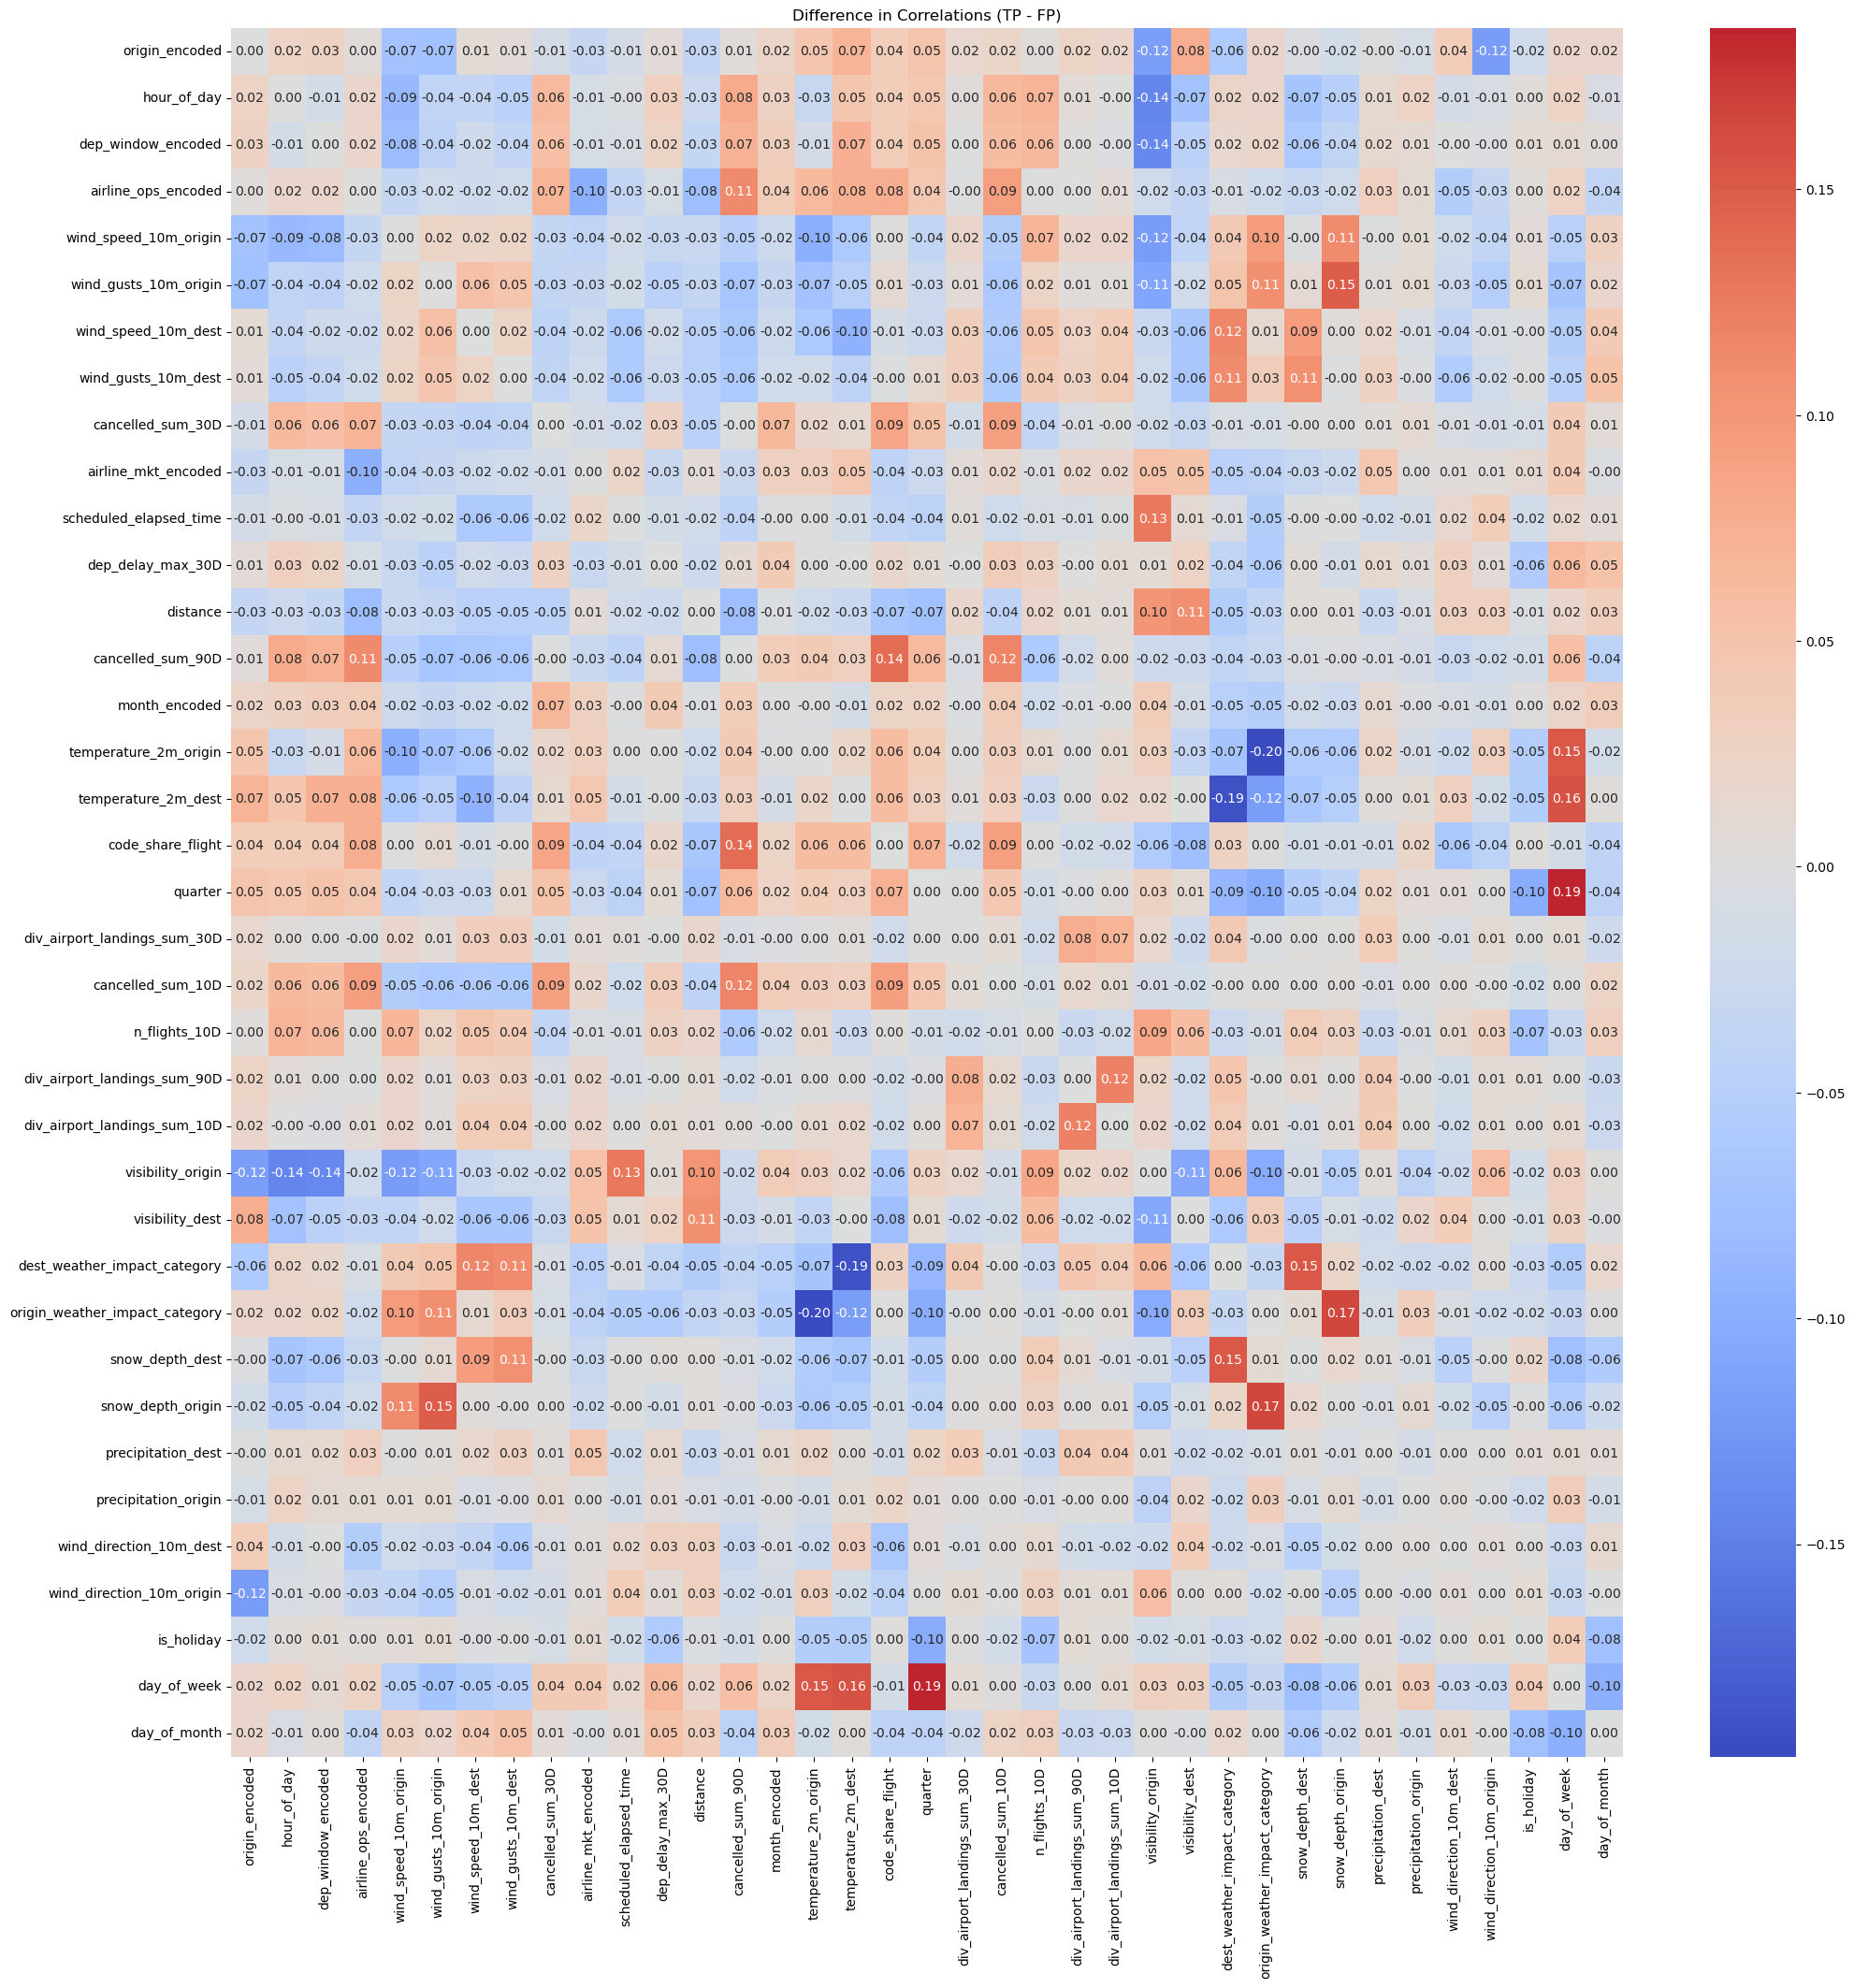

In [281]:
corr_diff = true_positive_corr - false_positive_corr

plt.figure(figsize=(24,24))
sns.heatmap(corr_diff, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Difference in Correlations (TP - FP)")
plt.show()

In [282]:
corr_diff_flat = corr_diff.unstack().reset_index()
corr_diff_flat.columns = ['Feature 1', 'Feature 2', 'Difference']
# Filter out self-correlations (where Feature 1 == Feature 2)
corr_diff_flat = corr_diff_flat[corr_diff_flat['Feature 1'] != corr_diff_flat['Feature 2']]

# Sort by absolute difference to find most significant correlations
corr_diff_flat['Abs Difference'] = corr_diff_flat['Difference'].abs()

# Display the top 10 strongest positive and negative differences
top_positive_diffs = corr_diff_flat.sort_values(by='Difference', ascending=False).head(10)
top_negative_diffs = corr_diff_flat.sort_values(by='Difference', ascending=True).head(10)

In [283]:
top_positive_diffs

,Feature 1,Feature 2,Difference,Abs Difference
1313,day_of_week,quarter,0.185703,0.185703
701,quarter,day_of_week,0.185703,0.185703
1100,snow_depth_origin,origin_weather_impact_category,0.165617,0.165617
1028,origin_weather_impact_category,snow_depth_origin,0.165617,0.165617
627,temperature_2m_dest,day_of_week,0.155988,0.155988
1311,day_of_week,temperature_2m_dest,0.155988,0.155988
1310,day_of_week,temperature_2m_origin,0.152417,0.152417
590,temperature_2m_origin,day_of_week,0.152417,0.152417
990,dest_weather_impact_category,snow_depth_dest,0.151459,0.151459
1062,snow_depth_dest,dest_weather_impact_category,0.151459,0.151459


In [284]:
top_negative_diffs

,Feature 1,Feature 2,Difference,Abs Difference
1014,origin_weather_impact_category,temperature_2m_origin,-0.197110,0.197110
582,temperature_2m_origin,origin_weather_impact_category,-0.197110,0.197110
978,dest_weather_impact_category,temperature_2m_dest,-0.190629,0.190629
618,temperature_2m_dest,dest_weather_impact_category,-0.190629,0.190629
61,hour_of_day,visibility_origin,-0.143460,0.143460
889,visibility_origin,hour_of_day,-0.143460,0.143460
98,dep_window_encoded,visibility_origin,-0.141407,0.141407
890,visibility_origin,dep_window_encoded,-0.141407,0.141407
33,origin_encoded,wind_direction_10m_origin,-0.120825,0.120825
1221,wind_direction_10m_origin,origin_encoded,-0.120825,0.120825


<Axes: >

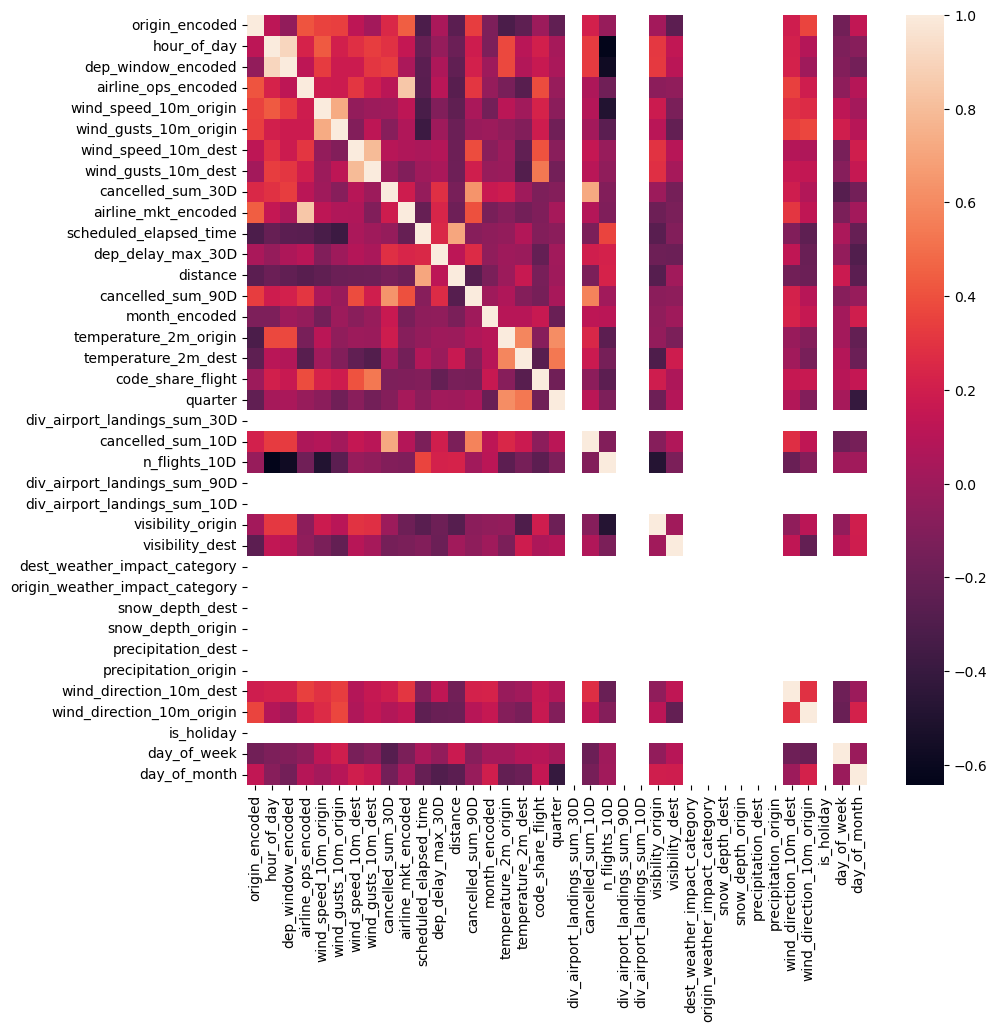

In [285]:
fig, ax = plt.subplots(figsize=(10,10))
false_negative_corr = false_negatives.corr()
sns.heatmap(false_negative_corr)